In [1]:
import glob
from itertools import product
import itertools

import altair as alt
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sourmash import signature as sig
from tqdm import tqdm

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import common

figure_folder = common.get_figure_folder()
! mkdir -p $figure_folder
figure_folder

'../figures/084_analyze_5cells_from_tissue_subset_scaled_and_numhashes'

## Load a few signatures

In [ ]:
n_signatures = 10

folder = '/home/olga/scratch-pure/maca/facs/sourmash_compute_tissue_subset/'

filenames = sorted(glob.glob(f'{folder}/*.sig'))
filenames = filenames[:n_signatures]
print(f'len(filenames): {len(filenames)}')

siglist_subset = []

for filename in tqdm(filenames):
    loaded = sig.load_signatures(filename)
    siglist_subset.extend(loaded)

  0%|          | 0/10 [00:00<?, ?it/s]

len(filenames): 10


 60%|██████    | 6/10 [28:26<19:15, 288.91s/it]

In [5]:
s = siglist_subset[0]
dir(s.minhash)

IndexError: list index out of range

In [ ]:
ksizes = 21, 27, 33, 51

In [ ]:
# %%file sourmash_compare_utils.py

# import jaccard_utils

# import itertools

# from scipy.spatial.distance import squareform


# def _compare_serial(siglist, iterator):
#     n = len(siglist)
#     values = np.ones((n, n))
    
#     for i, j in iterator:
#         jaccard = jaccard_utils.jaccard_sigs(i, j, siglist)
        
#         values[i, j] = jaccard
#         values[j, i] = jaccard
        
#     return values


# def compare_all_pairs(siglist, n_jobs=None):
#     n = len(siglist)
#     iterator = itertools.combinations(range(n), 2)
    
    
#     if n_jobs is None:
#         values = _compare_serial(siglist, iterator)
#     else:
#         # This creates a condensed distance matrix
#         condensed = Parallel(n_jobs=n_jobs)(delayed(jaccard_utils.jaccard_sigs)(i, j, siglist) for i, j in iterator)
#         values = squareform(condensed)
        
#     return values

In [ ]:
from sourmash_utils import filter_siglist
from sourmash_compare_utils import compare_all_pairs

In [ ]:
%time siglist_k27_dna = filter_siglist(siglist_subset, 27, 'DNA')
len(siglist_k27_dna)

In [ ]:
names = [s.name() for s in siglist_k27_dna]
names

In [ ]:
# %%file downsample_hashes.py


# import time

# import pandas as pd

# from sourmash_compare_utils import compare_all_pairs

# num_hashess = 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000


# def downsample_siglist(siglist, downsample_num_hashes=None, downsample_scaled=None):
#     if downsample_n is not None:
#         siglist_downsampled = [s.minhash.downsample_n(downsample_num_hashes) for s in siglist]
#     elif downsample_scaled is not None:
#         siglist_downsampled = [s.minhash.downsample_scaled(downsample_scaled) for s in siglist]
#     else:
#         raise ValueError("Either downsample_num_hashes or downsample_scaled must be specified!")
#     return siglist_downsampled


# def compare_downsampled(siglist, num_hashes=None, scaled=None, names=None):
#     siglist_downsampled = downsample_siglist(siglist, downsample_num_hashes=num_hashes,
#                                              downsample_scaled=scaled)
    
#     if names is None:
#         names = [s.name() for s in siglist]
#     assert len(names) == len(siglist)
    
#     t0 = time.time()
#     values = compare_all_pairs(siglist_downsampled)
#     time_delta = time.time() - t0
    
#     df = pd.DataFrame(values, index=names, columns=names).unstack().reset_index()
#     df = df.rename(columns={'level_0': 'cell1', 'level_1': 'cell2', 0: 'similarity'})
    
#     # Remove all self-similarity
#     df = df.query('similarity < 1')
#     df.loc[:, 'num_hashes'] = num_hashes
#     df.loc[:, 'time_seconds'] = time_delta
#     return df


# def subset_ksize_moltype_and_compare_numhashes(siglist, ksize, molecule,
#                                                num_hashes_to_downsample=num_hashess):
#     siglist_filtered = filter_siglist(siglist_subset, ksize, molecule)
#     names = [s.name() for s in siglist_filtered]
    
#     dfs = []

#     for num_hashes in num_hashess:
#         print(f'\tnum_hashes: {num_hashes}')
#         df = compare_num_hashes(siglist_filtered, num_hashes, names=names)
#         dfs.append(df)
#     similarity_filtered = pd.concat(dfs)
#     print(similarity_filtered.shape)
    
#     similarity_filtered.loc[:, 'ksize'] = ksize
#     similarity_filtered.loc[:, 'molecule'] = molecule
#     return similarity_filtered



In [ ]:
from downsample_hashes import compare_downsampled, subset_ksize_moltype_and_compare_numhashes

In [6]:
num_hashess = 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000

dfs = []

for num_hashes in num_hashess:
    print(f'num_hashes: {num_hashes}')
    df = compare_downsampled(siglist_k27_dna, num_hashes=num_hashes, names=names)
    dfs.append(df)
similarity_k27_dna = pd.concat(dfs)
print(similarity_k27_dna.shape)
similarity_k27_dna.head()

num_hashes: 100


NameError: name 'compare_downsampled' is not defined

In [7]:
import seaborn as sns

sns.factorplot(data=similarity_k27_dna, x='num_hashes', y='time_seconds')

NameError: name 'similarity_k27_dna' is not defined

In [23]:
import warnings
warnings.filterwarnings('once')

In [22]:
molecules = 'DNA', 'protein'
ksizes = 21, 27, 33, 51
dfs = []

for molecule, ksize in itertools.product(molecules, ksizes):
    print('---')
    print(f'molecule: {molecule}, ksize: {ksize}')
    df = subset_ksize_moltype_and_compare_numhashes(siglist_subset, ksize, molecule)
    print('\tdf.shape')
    dfs.append(df)
similarity_ksize_moltype = pd.concat(dfs)
print(similarity_ksize_moltype.shape)
similarity_ksize_moltype.head()

---
molecule: DNA, ksize: 21
	num_hashes: 100


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
	num_hashes: 20000
	num_hashes: 50000
	num_hashes: 100000
(900, 5)
	df.shape
---
molecule: DNA, ksize: 27
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
	num_hashes: 20000
	num_hashes: 50000
	num_hashes: 100000
(720, 5)
	df.shape
---
molecule: DNA, ksize: 33
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
	num_hashes: 20000
	num_hashes: 50000
	num_hashes: 100000
(900, 5)
	df.shape
---
molecule: DNA, ksize: 51
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_hashes: 5000
	num_hashes: 10000
	num_hashes: 20000
	num_hashes: 50000
	num_hashes: 100000
(900, 5)
	df.shape
---
molecule: protein, ksize: 21
	num_hashes: 100
	num_hashes: 200
	num_hashes: 500
	num_hashes: 1000
	num_hashes: 2000
	num_h

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
1,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:...,0.00,100,0.002416,21,DNA
2,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue...,A1-MAA000487-3_10_M-1-1|tissue:Bladder|subtiss...,0.01,100,0.002416,21,DNA
3,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue...,A1-MAA000779-3_11_M-1-1|tissue:Spleen|subtissu...,0.02,100,0.002416,21,DNA
4,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue...,A1-MAA100039-3_11_M-1-1|tissue:Liver|subtissue...,0.01,100,0.002416,21,DNA
5,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue...,A10-B000971-3_39_F-1-1|tissue:Spleen|subtissue...,0.03,100,0.002416,21,DNA


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


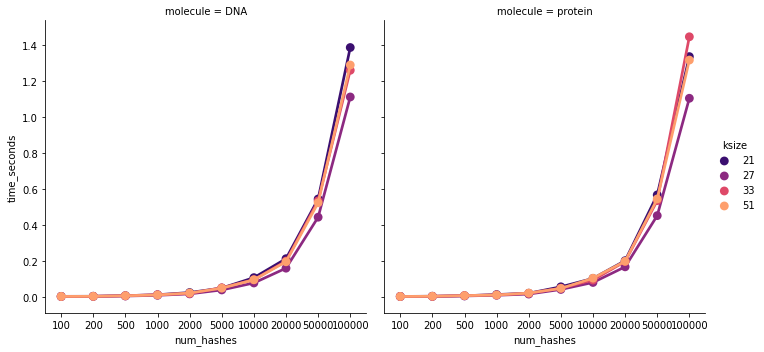

In [28]:
import seaborn as sns

sns.factorplot(data=similarity_ksize_moltype, x='num_hashes', y='time_seconds', 
               col='molecule', hue='ksize', palette='magma')

In [24]:
pd.options.display.max_colwidth = 100

In [25]:
cell1 = 'A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotation:Bladder_mesenchymal_cell'
cell1_similarity = similarity_ksize_moltype.query('(cell1 == @cell1) & (cell2 != @cell1)')
cell1_similarity.head()

,cell1,cell2,similarity,num_hashes,time_seconds,ksize,molecule
10,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,0.00,100,0.002416,21,DNA
12,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,A1-MAA000487-3_10_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annota...,0.07,100,0.002416,21,DNA
13,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,A1-MAA000779-3_11_M-1-1|tissue:Spleen|subtissue:NA|cell_ontology_class:B_cell|free_annotation:NA,0.02,100,0.002416,21,DNA
14,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,A1-MAA100039-3_11_M-1-1|tissue:Liver|subtissue:Hepatocytes|cell_ontology_class:hepatocyte|free_a...,0.06,100,0.002416,21,DNA
15,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,A10-B000971-3_39_F-1-1|tissue:Spleen|subtissue:NA|cell_ontology_class:T_cell|free_annotation:NA,0.01,100,0.002416,21,DNA


In [26]:

import altair as alt

FACET = {"row": "cell2", "col": "molecule"}


alt.FacetChart(cell1_similarity, facet=FACET).mark_line(point=True).encode(
    x='num_hashes', y='similarity')

AttributeError: 'UndefinedType' object has no attribute 'get'

In [64]:
plt.plot?

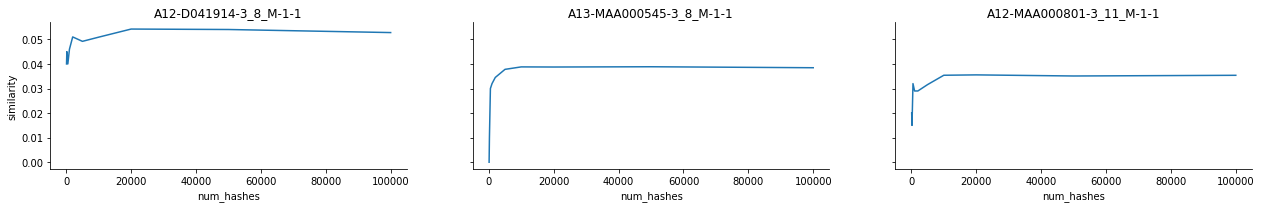

In [66]:
g = sns.FacetGrid(cell1_similarity, col='cell2', aspect=2)
g.map(plt.plot, 'num_hashes', 'similarity')
for ax in g.axes.flat:
    title = ax.get_title()
    new_title = title.split('cell2 = ')[1].split('|')[0]
    ax.set_title(new_title)
g.fig.tight_layout()

In [ ]:
g = sns.FacetGrid(cell1_similarity, col='cell2', aspect=2)
g.map(plt.semilogy, 'num_hashes', 'similarity')
for ax in g.axes.flat:
    title = ax.get_title()
    new_title = title.split('cell2 = ')[1].split('|')[0]
    ax.set_title(new_title)
g.fig.tight_layout()

In [119]:
import knn


In [120]:
annotations = pd.read_csv("/home/olga/tabula-muris/00_data_ingest/18_global_annotation_csv/annotations_facs.csv")
annotations['cell'] = annotations['cell'].str.replace('.', '-')
print(annotations.shape)
annotations.head()

(44949, 24)


/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Neurog3>0_raw,Neurog3>0_scaled,cell,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
0,NaN,NaN,A1-B000610-3_56_F-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.182841,-10.895094
1,NaN,NaN,A1-B002764-3_38_F-1-1,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,4.199059,-11.050240
2,NaN,NaN,A1-B002771-3_39_F-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-11.995435,-7.325534
3,NaN,NaN,A1-D041914-3_8_M-1-1,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-6.820022,-14.174246
4,NaN,NaN,A1-D042253-3_9_M-1-1,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-24.163538,-7.499349


In [121]:
cell_ids_k27_dna = [s.name().split('|')[0] for s in siglist_k27_dna]
cell_ids_k27_dna[:5]

['D16-B000610-3_56_F-1-1',
 'J8-D041914-3_8_M-1-1',
 'A10-D041914-3_8_M-1-1',
 'K1-B000610-3_56_F-1-1',
 'O1-B002771-3_39_F-1-1']

In [29]:
from sourmash_compare_utils import get_similarity_difference

In [31]:
similarity_difference = get_similarity_difference(similarity_ksize_moltype)
print(similarity_difference.shape)
similarity_difference.head()

/home/olga/code/kmer-hashing/notebooks/sourmash_compare_utils.py:57: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


(49248, 6)


,cell1,cell2,ksize,molecule,num_hashes,similarity_difference
0,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,21,DNA,100,-0.02149
1,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,21,DNA,200,-0.00649
2,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,21,DNA,500,-0.00949
3,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,21,DNA,1000,-0.00349
4,A1-B002764-3_38_F-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_urothelial_cell|fr...,A1-D042253-3_9_M-1-1|tissue:Bladder|subtissue:NA|cell_ontology_class:bladder_cell|free_annotatio...,21,DNA,2000,0.00251


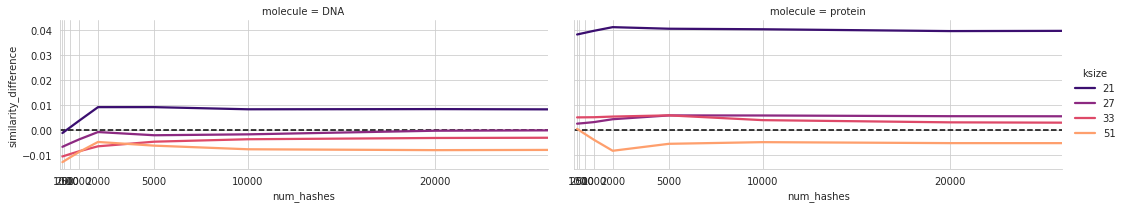

In [36]:
max_num_hashes = similarity_difference.num_hashes.max()
xticks = similarity_difference['num_hashes'].unique()

sns.set_style('whitegrid')

g = sns.FacetGrid(similarity_difference, col='molecule', hue='ksize', palette='magma', aspect=2.5)
g.map(sns.regplot, 'num_hashes', 'similarity_difference',  lowess=True, scatter=False)
g.set(xlim=(-50, max_num_hashes*.52), xticks=xticks)
for ax in g.axes.flat:
    xmin, xmax = ax.get_xlim()
    ax.hlines(0, xmin, xmax, color='k', linestyle='--')
g.add_legend()

In [122]:
metadata = annotations.query('cell in @cell_ids_k27_dna').set_index('cell')
print(metadata.shape)
metadata.head()

(49, 23)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster.ids,free_annotation,mouse.id,mouse.sex,plate.barcode,subsetA,...,subsetC,subsetC_cluster.ids,subsetD,subsetD_cluster.ids,subsetE,subsetE_cluster.ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2
cell,,,,,,,,,,,,,,,,,,,,,
A10-D041914-3_8_M-1-1,NaN,NaN,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_8_M,M,D041914,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-16.643703,-2.434115
C1-B002771-3_39_F-1-1,NaN,NaN,bladder cell,CL:1001319,0,Bladder mesenchymal cell,3_39_F,F,B002771,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,6.323991,-20.799954
D16-B000610-3_56_F-1-1,NaN,NaN,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-3.680862,-7.935199
G2-MAA000487-3_10_M-1-1,NaN,NaN,bladder cell,CL:1001319,0,Bladder mesenchymal cell,3_10_M,M,MAA000487,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-7.573929,-25.838321
H2-D041914-3_8_M-1-1,NaN,NaN,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_8_M,M,D041914,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bladder,-19.457846,7.086368


In [123]:
jaccard_1m = pd.DataFrame(values, index=cell_ids_k27_dna, columns=cell_ids_k27_dna)
jaccard_1m.head()

,D16-B000610-3_56_F-1-1,J8-D041914-3_8_M-1-1,A10-D041914-3_8_M-1-1,K1-B000610-3_56_F-1-1,O1-B002771-3_39_F-1-1,H2-D041914-3_8_M-1-1,C1-B002771-3_39_F-1-1,P2-B000610-3_56_F-1-1,I6-D041914-3_8_M-1-1,G2-MAA000487-3_10_M-1-1,...,O18-MAA001862-3_39_F-1-1,M13-B001750-3_38_F-1-1,C16-B000971-3_39_F-1-1,L19-B001750-3_38_F-1-1,A19-B000971-3_39_F-1-1,K4-MAA000508-3_9_M-1-1,D22-MAA000776-3_10_M-1-1,I20-B000971-3_39_F-1-1,G4-B001750-3_38_F-1-1,G10-B001750-3_38_F-1-1
D16-B000610-3_56_F-1-1,1.000000,0.075768,0.070774,0.075483,0.061413,0.084365,0.079117,0.082958,0.074517,0.055713,...,0.048662,0.040939,0.037233,0.042356,0.037722,0.038222,0.033112,0.040544,0.044088,0.039500
J8-D041914-3_8_M-1-1,0.075768,1.000000,0.110656,0.095762,0.094588,0.113787,0.110328,0.087658,0.107888,0.095467,...,0.080262,0.047532,0.040653,0.043899,0.044750,0.039540,0.039569,0.047962,0.047579,0.043913
A10-D041914-3_8_M-1-1,0.070774,0.110656,1.000000,0.089041,0.084941,0.114014,0.096012,0.083851,0.113230,0.095182,...,0.077649,0.047329,0.041871,0.043327,0.045125,0.038878,0.039886,0.048923,0.047328,0.043935
K1-B000610-3_56_F-1-1,0.075483,0.095762,0.089041,1.000000,0.080479,0.093818,0.096238,0.083216,0.086865,0.078582,...,0.068187,0.044781,0.037555,0.040809,0.041846,0.037676,0.034827,0.044738,0.044295,0.040594
O1-B002771-3_39_F-1-1,0.061413,0.094588,0.084941,0.080479,1.000000,0.086823,0.088497,0.068989,0.084056,0.081769,...,0.066603,0.040245,0.035381,0.036368,0.039008,0.032765,0.033826,0.042489,0.039067,0.037353


In [124]:
jaccard_1k = pd.DataFrame(values_numhashes, index=cell_ids_k27_dna, columns=cell_ids_k27_dna)
jaccard_1k.head()

,D16-B000610-3_56_F-1-1,J8-D041914-3_8_M-1-1,A10-D041914-3_8_M-1-1,K1-B000610-3_56_F-1-1,O1-B002771-3_39_F-1-1,H2-D041914-3_8_M-1-1,C1-B002771-3_39_F-1-1,P2-B000610-3_56_F-1-1,I6-D041914-3_8_M-1-1,G2-MAA000487-3_10_M-1-1,...,O18-MAA001862-3_39_F-1-1,M13-B001750-3_38_F-1-1,C16-B000971-3_39_F-1-1,L19-B001750-3_38_F-1-1,A19-B000971-3_39_F-1-1,K4-MAA000508-3_9_M-1-1,D22-MAA000776-3_10_M-1-1,I20-B000971-3_39_F-1-1,G4-B001750-3_38_F-1-1,G10-B001750-3_38_F-1-1
D16-B000610-3_56_F-1-1,1.000,0.077,0.061,0.070,0.055,0.080,0.072,0.078,0.063,0.056,...,0.036,0.027,0.027,0.033,0.027,0.030,0.020,0.025,0.039,0.031
J8-D041914-3_8_M-1-1,0.077,1.000,0.099,0.102,0.092,0.113,0.108,0.084,0.108,0.103,...,0.073,0.043,0.037,0.049,0.041,0.037,0.029,0.043,0.046,0.038
A10-D041914-3_8_M-1-1,0.061,0.099,1.000,0.088,0.088,0.126,0.089,0.082,0.115,0.097,...,0.071,0.043,0.038,0.045,0.046,0.038,0.037,0.058,0.041,0.040
K1-B000610-3_56_F-1-1,0.070,0.102,0.088,1.000,0.065,0.093,0.084,0.087,0.075,0.076,...,0.062,0.042,0.032,0.039,0.030,0.035,0.028,0.038,0.039,0.031
O1-B002771-3_39_F-1-1,0.055,0.092,0.088,0.065,1.000,0.081,0.079,0.070,0.079,0.076,...,0.059,0.036,0.036,0.037,0.042,0.033,0.025,0.045,0.031,0.029


In [140]:



palettes = dict(tissue='husl', cell_ontology_class='tab10')
color_cols = ['cell_ontology_class', 'tissue']




n_neighbors = 5

graph_1m = knn.nearest_neighbor_graph(jaccard_1m, metadata, n_neighbors=n_neighbors, 
                                      color_cols=color_cols, palettes=palettes)
graph_1m

In [141]:
metadata.groupby('tissue').apply(lambda x: x['cell_ontology_class'].mode()[0])

tissue
Bladder                           bladder cell
Kidney      epithelial cell of proximal tubule
Liver                               hepatocyte
Pancreas                type B pancreatic cell
Spleen                                  B cell
dtype: object

In [142]:
import networkx as nx

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


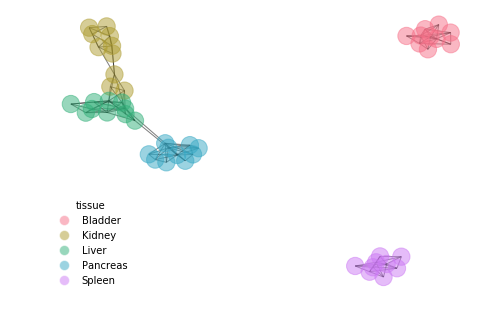

In [143]:
pos = nx.spring_layout(graph_1m, seed=0)

label = 'tissue'
knn.draw_graph(graph_1m, edge_color='black', pos=pos, label_col=label,)

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


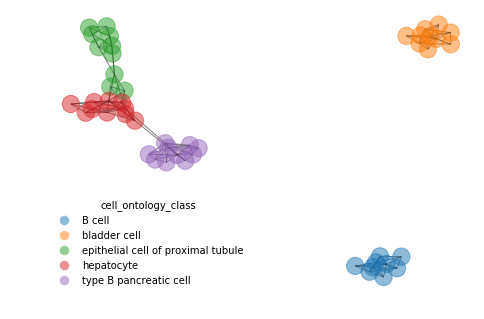

In [144]:
pos = nx.spring_layout(graph_1m, seed=0)

label = 'cell_ontology_class'
knn.draw_graph(graph_1m, edge_color='black', pos=pos, label_col=label,)

In [145]:
graph == graph_1m

False

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


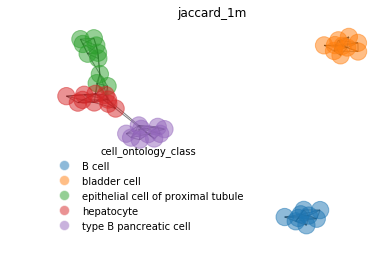

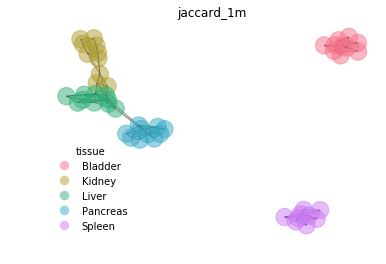

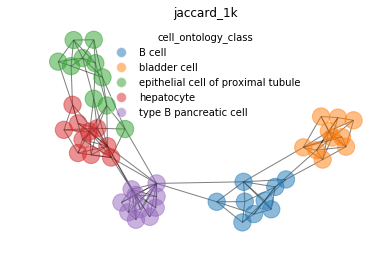

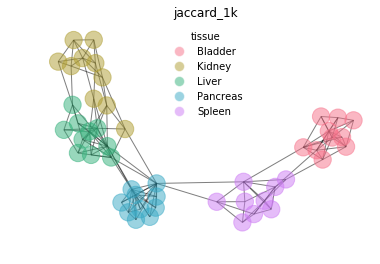

In [146]:
jaccards = dict(jaccard_1m=jaccard_1m, jaccard_1k=jaccard_1k)


for name, data in jaccards.items():
    graph = knn.nearest_neighbor_graph(data, metadata, n_neighbors=n_neighbors, 
                                      color_cols=color_cols, palettes=palettes)
    pos = nx.spring_layout(graph, seed=0)

    for label in color_cols:
        fig, ax = plt.subplots()
        knn.draw_graph(graph, edge_color='black', pos=pos, label_col=label,)
        ax.set_title(name)

In [132]:
compare_vanilla = pd.DataFrame(values, index=names, columns=names)
compare_vanilla.head()

NameError: name 'names' is not defined

In [ ]:
%%time
n_jobs = 8

values_idf = Parallel(n_jobs=n_jobs)(delayed(jaccard_sigs_idf)(i, j, siglist, inverse_document_frequency, mean_idf_per_cell) 
                                 for i, j in itertools.product(range(nrow), range(ncol)))

In [ ]:
compare_idf = pd.DataFrame(values_idf, index=names, columns=names)